In [ ]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Add, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
isles_dir = '/content/drive/My Drive/ISLES-2022/'
def paths_case(case_id):
    dwi_path = os.path.join(isles_dir, 'data', 'rawdata', 'sub-strokecase{}'.format("%04d" % case_id), 'ses-0001', 'dwi',
                            'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" % case_id))
    mask_path = os.path.join(isles_dir, 'derivatives', 'sub-strokecase{}'.format("%04d" % case_id), 'ses-0001',
                             'sub-strokecase{}_ses-0001_msk.nii.gz'.format("%04d" % case_id))

    dwi_image = nib.load(dwi_path).get_fdata()
    mask_image = nib.load(mask_path).get_fdata()

    return  dwi_path, mask_path, dwi_image, mask_image

-------------------------------------------------------------------------------------------------------

In [ ]:
#Diccionarios para contar formas unicas
dwi_shapes = defaultdict(int)
mask_shapes = defaultdict(int)

for case_id in range(1, 251):
    try:
        dwi_image, mask_image = paths_case(case_id)

        # Registrar shapes
        dwi_shapes[dwi_image.shape] += 1
        mask_shapes[mask_image.shape] += 1

    except Exception as e:
        print(f"Error al procesar el caso {case_id}: {e}")

print("Shapes únicas de imágenes DWI:")
for shape, count in dwi_shapes.items():
    print(f"{shape}: {count} casos")

print("\nShapes únicas de máscaras :")
for shape, count in mask_shapes.items():
    print(f"{shape}: {count} casos")

Shapes únicas de imágenes DWI y sus frecuencias:
(112, 112, 73): 93 casos
(112, 112, 72): 92 casos
(130, 130, 65): 1 casos
(115, 115, 28): 1 casos
(128, 128, 72): 2 casos
(115, 115, 75): 1 casos
(256, 256, 73): 2 casos
(112, 112, 74): 1 casos
(170, 170, 33): 1 casos
(115, 115, 70): 1 casos
(112, 112, 75): 1 casos
(128, 128, 25): 27 casos
(192, 192, 30): 23 casos
(112, 112, 76): 1 casos
(128, 128, 27): 1 casos
(122, 122, 63): 1 casos
(128, 128, 30): 1 casos

Shapes únicas de máscaras y sus frecuencias:
(112, 112, 73): 93 casos
(112, 112, 72): 92 casos
(130, 130, 65): 1 casos
(115, 115, 28): 1 casos
(128, 128, 72): 2 casos
(115, 115, 75): 1 casos
(256, 256, 73): 2 casos
(112, 112, 74): 1 casos
(170, 170, 33): 1 casos
(115, 115, 70): 1 casos
(112, 112, 75): 1 casos
(128, 128, 25): 27 casos
(192, 192, 30): 23 casos
(112, 112, 76): 1 casos
(128, 128, 27): 1 casos
(122, 122, 63): 1 casos
(128, 128, 30): 1 casos


In [ ]:
def resize_image(dwi_image, mask_image, target_shape=(112, 112, 73)):
    dwi_resized = zoom(dwi_image,
                       (target_shape[0] / dwi_image.shape[0],
                        target_shape[1] / dwi_image.shape[1],
                        target_shape[2] / dwi_image.shape[2]), order=1)

    mask_resized = zoom(mask_image,
                        (target_shape[0] / mask_image.shape[0],
                         target_shape[1] / mask_image.shape[1],
                         target_shape[2] / mask_image.shape[2]), order=1)

    return dwi_resized, mask_resized

In [ ]:
def process_and_count_cases(case_ids, target_shape=(112, 112, 73)):
    count = 0

    for case_id in case_ids:
        dwi_image, mask_image = paths_case(case_id)
        dwi_resized, mask_resized = resize_image(dwi_image, mask_image, target_shape)

        if dwi_resized.shape == target_shape and mask_resized.shape == target_shape:
            count += 1
            print(f"Caso {case_id}: {target_shape}")

    print(f"\nTotal de casos con shape {target_shape}: {count}")

case_ids = list(range(1, 251))
process_and_count_cases(case_ids)

Case 1 has the target shape (112, 112, 73)
Case 2 has the target shape (112, 112, 73)
Case 3 has the target shape (112, 112, 73)
Case 4 has the target shape (112, 112, 73)
Case 5 has the target shape (112, 112, 73)
Case 6 has the target shape (112, 112, 73)
Case 7 has the target shape (112, 112, 73)
Case 8 has the target shape (112, 112, 73)
Case 9 has the target shape (112, 112, 73)
Case 10 has the target shape (112, 112, 73)
Case 11 has the target shape (112, 112, 73)
Case 12 has the target shape (112, 112, 73)
Case 13 has the target shape (112, 112, 73)
Case 14 has the target shape (112, 112, 73)
Case 15 has the target shape (112, 112, 73)
Case 16 has the target shape (112, 112, 73)
Case 17 has the target shape (112, 112, 73)
Case 18 has the target shape (112, 112, 73)
Case 19 has the target shape (112, 112, 73)
Case 20 has the target shape (112, 112, 73)
Case 21 has the target shape (112, 112, 73)
Case 22 has the target shape (112, 112, 73)
Case 23 has the target shape (112, 112, 7

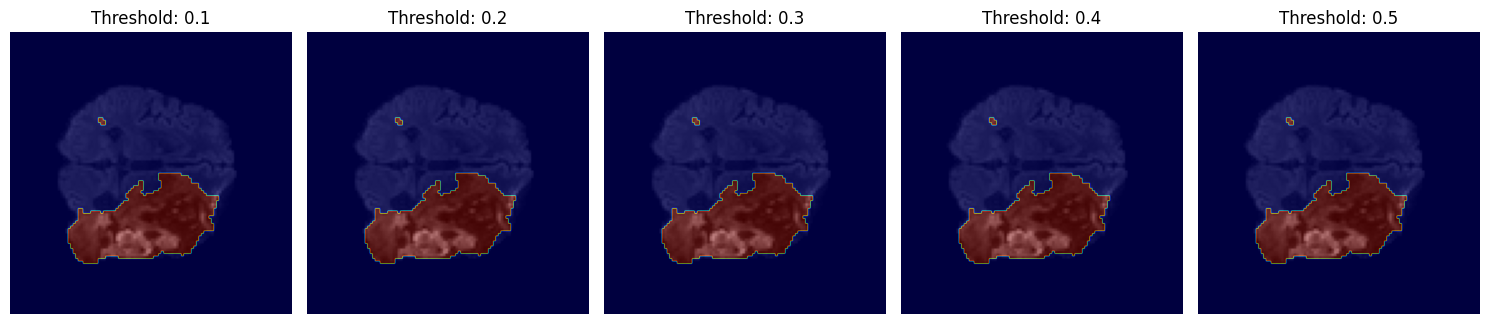

In [ ]:
def load_image_and_mask(case_id):
    dwi_path, mask_path, _, _ = paths_case(case_id)
    dwi_image = nib.load(dwi_path).get_fdata()
    mask_image = nib.load(mask_path).get_fdata()
    return dwi_image, mask_image

def visualize_thresholding(dwi_image, mask_image, thresholds):
    slice_index = 34
    fig, axes = plt.subplots(1, len(thresholds), figsize=(15, 5))

    for i, threshold in enumerate(thresholds):
        binary_mask = (mask_image[:, :, slice_index] > threshold).astype(int)

        axes[i].imshow(dwi_image[:, :, slice_index], cmap='gray')
        axes[i].imshow(binary_mask, cmap='jet', alpha=0.5)
        axes[i].set_title(f"Threshold: {threshold}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
case_id = 23
dwi_image, mask_image = load_image_and_mask(case_id)

visualize_thresholding(dwi_image, mask_image, thresholds)

In [ ]:
def normalize_image(image):
    image_min = np.min(image)
    image_max = np.max(image)

    if image_max == image_min:
        return image
    return (image - image_min) / (image_max - image_min)

In [ ]:
def extract_slices(dwi_image, mask_image, target_shape=(112, 112, 73), threshold=0.5):
    #Aplicar el umbral para convertir la máscara en binaria (0 y 1)
    binary_mask_image = (mask_image > threshold).astype(int)  #Binarizar la máscara

    dwi_slices = []
    mask_slices = []

    for i in range(dwi_image.shape[2]):
        #Usar la máscara binarizada para extraer las slices que contienen lesiones
        if np.any(binary_mask_image[:, :, i] > 0):
            dwi_slice = zoom(dwi_image[:, :, i],
                             (target_shape[0] / dwi_image.shape[0],
                              target_shape[1] / dwi_image.shape[1]), order=1)
            mask_slice = zoom(binary_mask_image[:, :, i],
                              (target_shape[0] / binary_mask_image.shape[0],
                               target_shape[1] / binary_mask_image.shape[1]), order=1)


            dwi_slice_normalized = normalize_image(dwi_slice)
            mask_slice_normalized = normalize_image(mask_slice)

            dwi_slices.append(dwi_slice_normalized)
            mask_slices.append(mask_slice_normalized)

    return np.array(dwi_slices), np.array(mask_slices)

In [ ]:
def process_slices(case_ids, target_shape=(112, 112, 73), test_size=0.1):
    all_dwi_slices = []
    all_mask_slices = []

    for case_id in case_ids:
        _, _, dwi_image, mask_image = paths_case(case_id)
        dwi_slices, mask_slices = extract_slices(dwi_image, mask_image, target_shape, threshold=0.5)

        if dwi_slices.size > 0 and mask_slices.size > 0:
            all_dwi_slices.append(dwi_slices)
            all_mask_slices.append(mask_slices)

        print(f"Caso {case_id}, {len(dwi_slices)} slices extraídas")

    all_dwi_slices = np.concatenate(all_dwi_slices, axis=0)
    all_mask_slices = np.concatenate(all_mask_slices, axis=0)

    x_train, x_test, y_train, y_test = train_test_split(
        all_dwi_slices, all_mask_slices, test_size=test_size, random_state=42
    )

    np.save('/content/drive/My Drive/ISLES-2022/x_train.npy', x_train)
    np.save('/content/drive/My Drive/ISLES-2022/y_train.npy', y_train)
    np.save('/content/drive/My Drive/ISLES-2022/x_test.npy', x_test)
    np.save('/content/drive/My Drive/ISLES-2022/y_test.npy', y_test)

    print(f"Datos guardados: {len(x_train)} para entrenamiento, {len(x_test)} para prueba.")

In [ ]:
case_ids = list(range(1, 251))
process_slices(case_ids)

Caso 1, 45 slices extraídas
Caso 2, 8 slices extraídas
Caso 3, 43 slices extraídas
Caso 4, 22 slices extraídas
Caso 5, 26 slices extraídas
Caso 6, 2 slices extraídas
Caso 7, 15 slices extraídas
Caso 8, 11 slices extraídas
Caso 9, 22 slices extraídas
Caso 10, 26 slices extraídas
Caso 11, 30 slices extraídas
Caso 12, 5 slices extraídas
Caso 13, 37 slices extraídas
Caso 14, 39 slices extraídas
Caso 15, 19 slices extraídas
Caso 16, 5 slices extraídas
Caso 17, 29 slices extraídas
Caso 18, 9 slices extraídas
Caso 19, 30 slices extraídas
Caso 20, 17 slices extraídas
Caso 21, 26 slices extraídas
Caso 22, 11 slices extraídas
Caso 23, 57 slices extraídas
Caso 24, 35 slices extraídas
Caso 25, 18 slices extraídas
Caso 26, 17 slices extraídas
Caso 27, 25 slices extraídas
Caso 28, 21 slices extraídas
Caso 29, 28 slices extraídas
Caso 30, 14 slices extraídas
Caso 31, 38 slices extraídas
Caso 32, 6 slices extraídas
Caso 33, 35 slices extraídas
Caso 34, 8 slices extraídas
Caso 35, 3 slices extraídas
Ca

------------------------------------------------------------------

In [ ]:
output_dir = '/content/drive/My Drive/ISLES-2022/'
x_train_path = os.path.join(output_dir, 'x_train.npy')
y_train_path = os.path.join(output_dir, 'y_train.npy')
x_test_path = os.path.join(output_dir, 'x_test.npy')
y_test_path = os.path.join(output_dir, 'y_test.npy')

x_train = np.load(x_train_path)
y_train = np.load(y_train_path)
x_test = np.load(x_test_path)
y_test = np.load(y_test_path)

print(f"min: {x_train.min()}, max: {x_train.max()}")
print(f"min: {y_train.min()}, max: {y_train.max()}")
print("-------------------------------------------")
print(f"min: {x_test.min()}, max: {x_test.max()}")
print(f"min: {y_test.min()}, max: {y_test.max()}")
print("-------------------------------------------")
print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)
print("Valores únicos en masks:", np.unique(y_train))

min: 0.0, max: 1.0
min: 0.0, max: 1.0
-------------------------------------------
min: 0.0, max: 1.0
min: 0.0, max: 1.0
-------------------------------------------
Train:  (4344, 112, 112) (4344, 112, 112)
Test:  (483, 112, 112) (483, 112, 112)
Valores únicos en masks: [0. 1.]


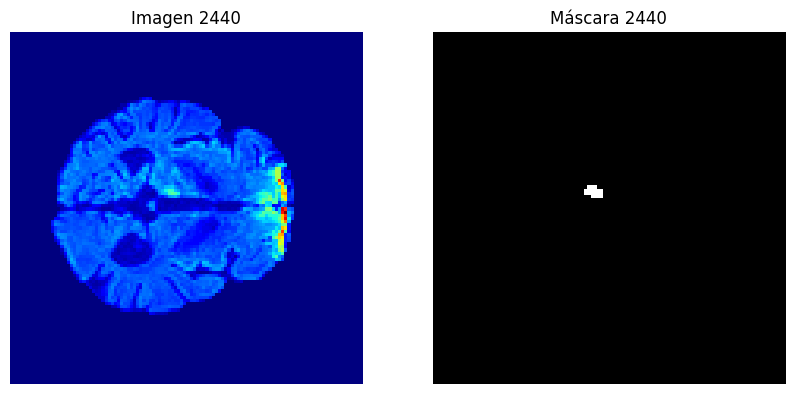

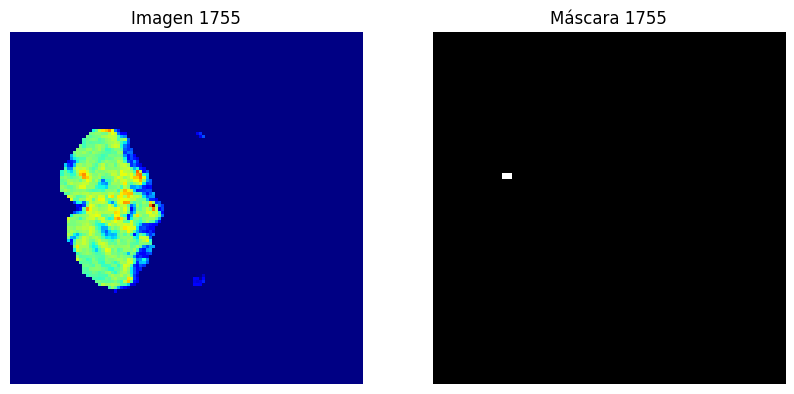

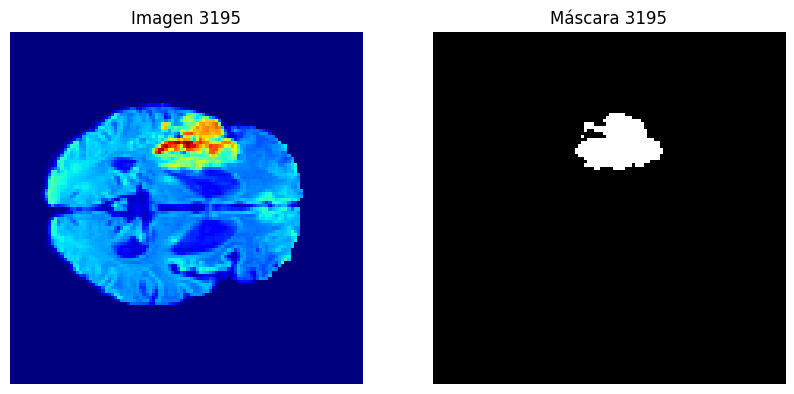

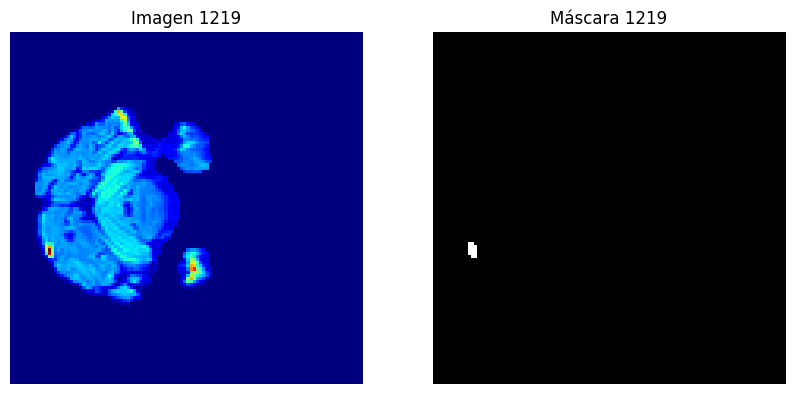

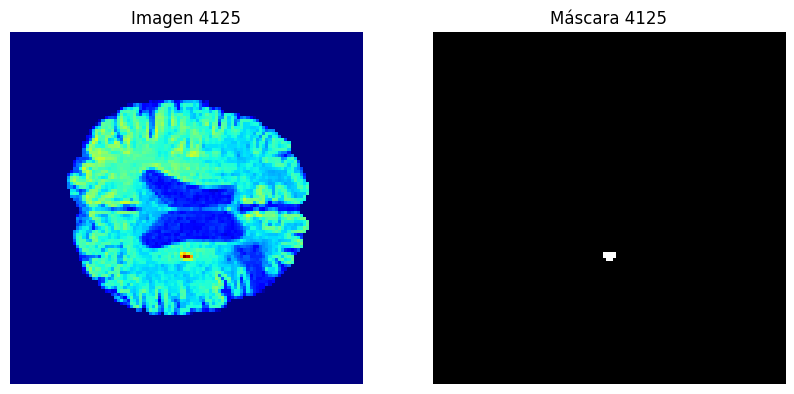

In [ ]:
num_images_to_display = 5
random_indices = random.sample(range(x_train.shape[0]), num_images_to_display)

for index in random_indices:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(x_train[index], cmap='jet')
    axes[0].set_title(f"Imagen {index}")
    axes[0].axis('off')

    axes[1].imshow(y_train[index], cmap='gray')
    axes[1].set_title(f"Máscara {index}")
    axes[1].axis('off')

    plt.show()

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True, leaky_relu = False):
    #layer 1
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    if leaky_relu:
        x = Activation('LeakyReLU')(x)
    else:
        x = Activation('relu')(x)

    #layer 2
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    if leaky_relu:
        x = Activation('LeakyReLU')(x)
    else:
        x = Activation('relu')(x)

    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, leaky_relu = False):
    #encoder
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)

    #decoder
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, leaky_relu = leaky_relu)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    # Flatten the tensors using tf.reshape
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Calculate the intersection and total
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    total = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    # Calculate the Dice coefficient
    dice = (2 * intersection + epsilon) / (total + epsilon)

    return dice

In [ ]:
def iou_loss(y_true, y_pred, smooth=1e-6):
    y_pred = K.sigmoid(y_pred)
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection

    iou = (intersection + smooth) / (union + smooth)
    loss = 1 - iou

    return loss

In [ ]:
input_img = Input((112, 112, 1), name='img')
model = get_unet(input_img)
model.summary()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=iou_loss,
    metrics=['binary_io_u']
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)          │ (None, 112, 112, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 112, 112, 16)   │            160 │ img[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 112, 112, 16)   │             64 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 112, 112, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 112, 112, 16)   │          2,320 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 112, 112, 16)   │             64 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 112, 112, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 16)     │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 56, 56, 16)     │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 56, 56, 32)     │          4,640 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 56, 56, 32)     │            128 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 56, 56, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 56, 56, 32)     │          9,248 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 56, 56, 32)     │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 56, 56, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 2,164,305 (8.26 MB)

 Trainable params: 2,161,361 (8.24 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
results = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=10,
    validation_split=0.1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1), # Reduce LR on plateau
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    ]
)

Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 644s 3s/step - binary_io_u: 0.5466 - loss: 0.9869 - val_binary_io_u: 0.5478 - val_loss: 0.9869 - learning_rate: 1.0000e-04
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - binary_io_u: 0.5619 - loss: 0.9861 - val_binary_io_u: 0.6137 - val_loss: 0.9868 - learning_rate: 1.0000e-04
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - binary_io_u: 0.5727 - loss: 0.9861 - val_binary_io_u: 0.6582 - val_loss: 0.9867 - learning_rate: 1.0000e-04
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - binary_io_u: 0.5874 - loss: 0.9854 - val_binary_io_u: 0.5664 - val_loss: 0.9867 - learning_rate: 1.0000e-04
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - binary_io_u: 0.5954 - loss: 0.9863 - val_binary_io_u: 0.5061 - val_loss: 0.9867 - learning_rate: 1.0000e-04
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - binary_io_u: 0.6004 - loss: 0.9857 - val_binary_io_u: 0.7251 - val_loss: 0.9865 - learning_rate: 1.0000e-04
Epoch 7/10
245/245 ━━━

In [ ]:
model.save('/content/drive/My Drive/ISLES-2022/unet_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


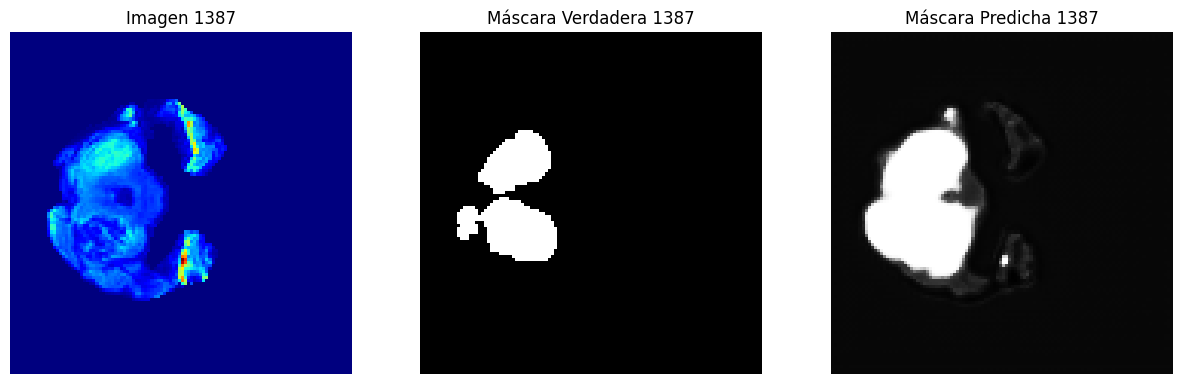

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


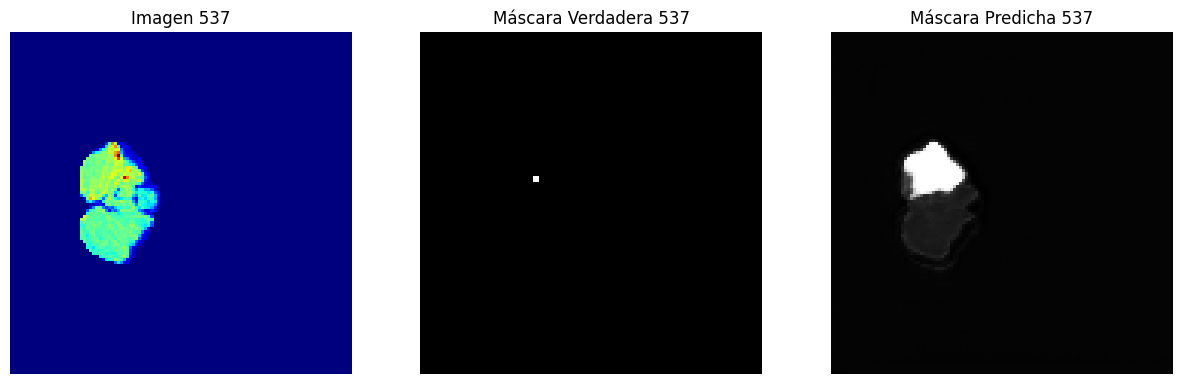

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


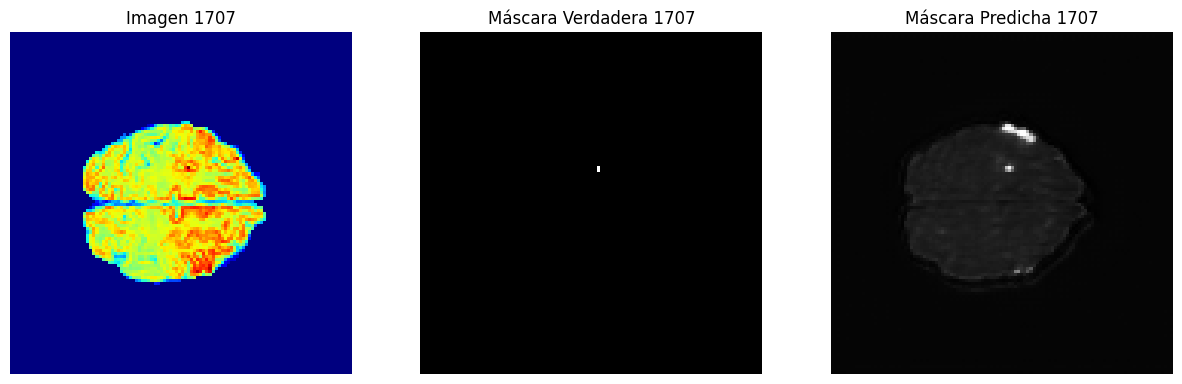

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


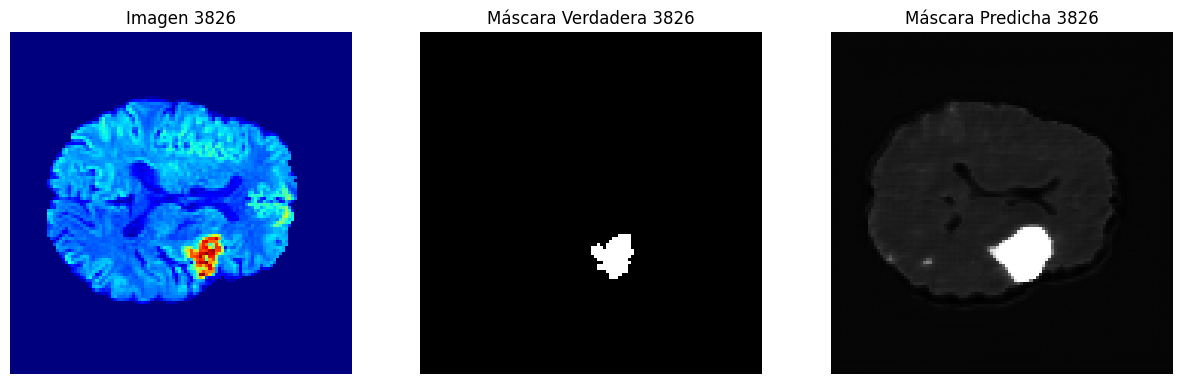

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


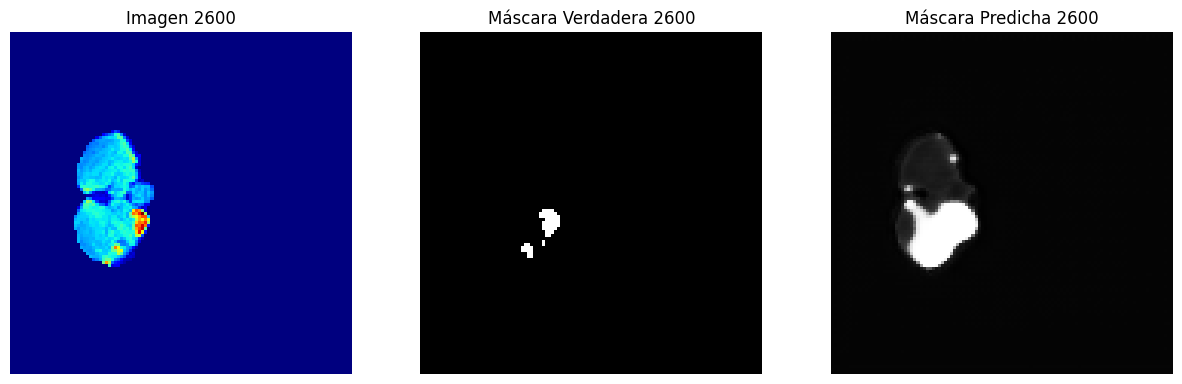

In [ ]:
num_images_to_display = 5
random_indices = random.sample(range(x_train.shape[0]), num_images_to_display)

for index in random_indices:
    predicted_mask = model.predict(np.expand_dims(x_train[index], axis=0))
    predicted_mask = predicted_mask[0, :, :, 0]  #Remove extra dimensions

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(x_train[index], cmap='jet')
    axes[0].set_title(f"Imagen {index}")
    axes[0].axis('off')

    axes[1].imshow(y_train[index], cmap='gray')
    axes[1].set_title(f"Máscara Verdadera {index}")
    axes[1].axis('off')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title(f"Máscara Predicha {index}")
    axes[2].axis('off')

    plt.show()

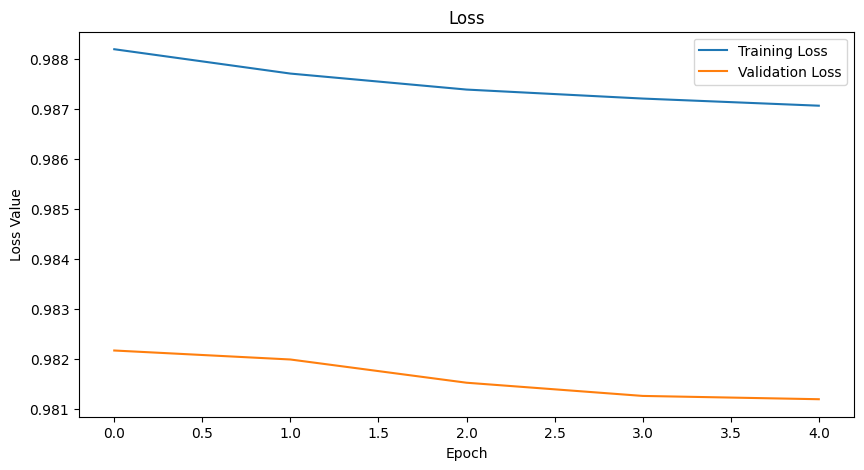

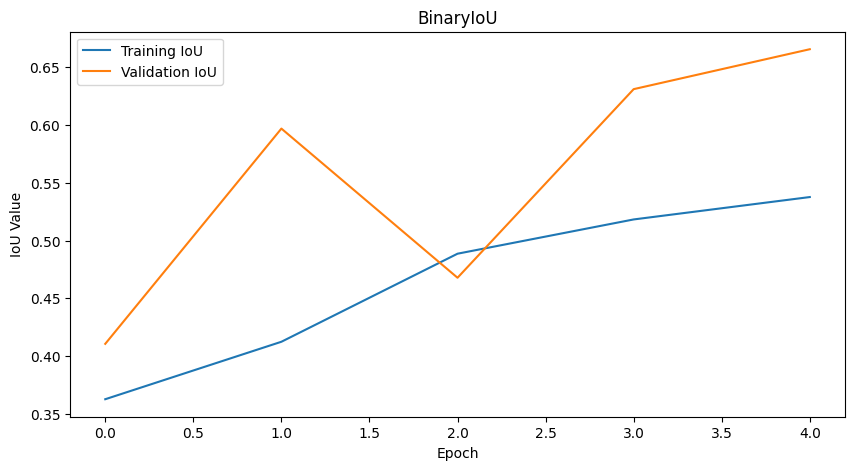

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results.history['binary_io_u'], label='Training IoU')
plt.plot(results.history['val_binary_io_u'], label='Validation IoU')
plt.title('BinaryIoU')
plt.ylabel('IoU Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
unet_model_path = '/content/drive/My Drive/ISLES-2022/unet_model.h5'
unet_model = tf.keras.models.load_model(unet_model_path, compile=False)

In [ ]:
test_loss, test_iou = model.evaluate(x_test, y_test, verbose=1)

print(f"Test loss: {test_loss}")
print(f"Test Dice coefficient: {test_iou}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - binary_io_u: 0.5715 - loss: 0.9858
Test loss: 0.9853360652923584
Test Dice coefficient: 0.5737254619598389


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


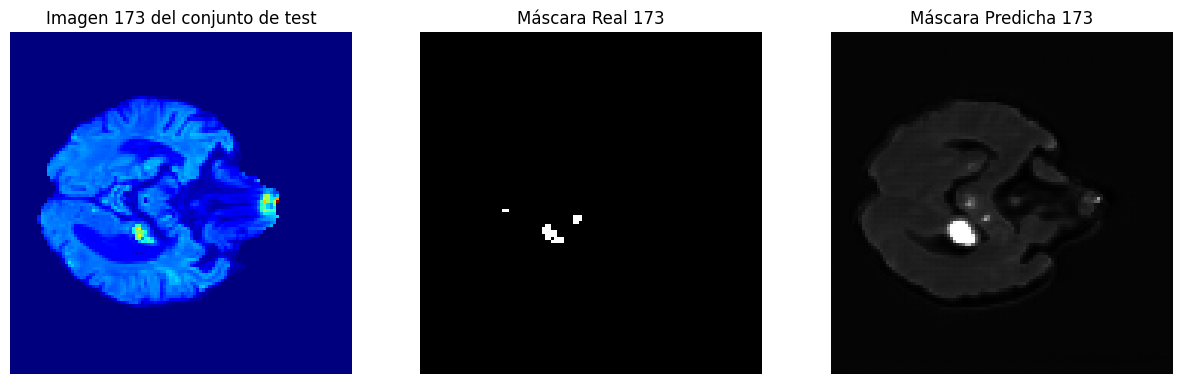

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


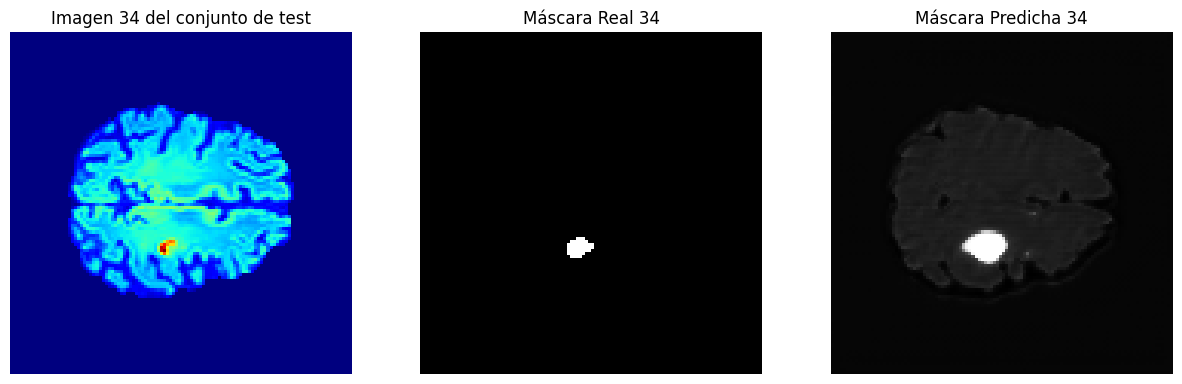

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


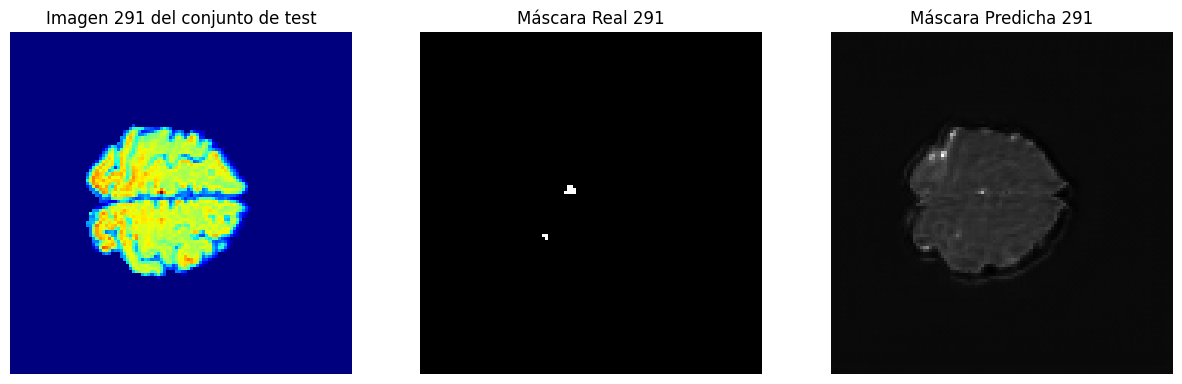

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


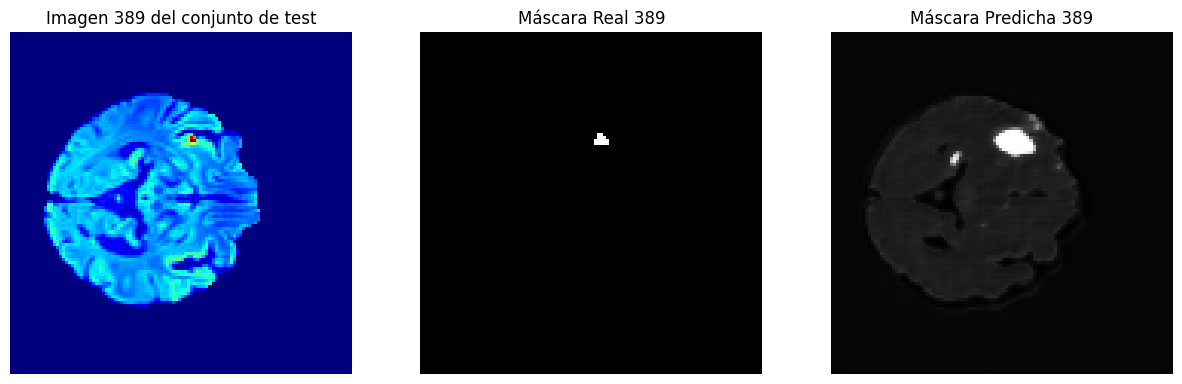

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


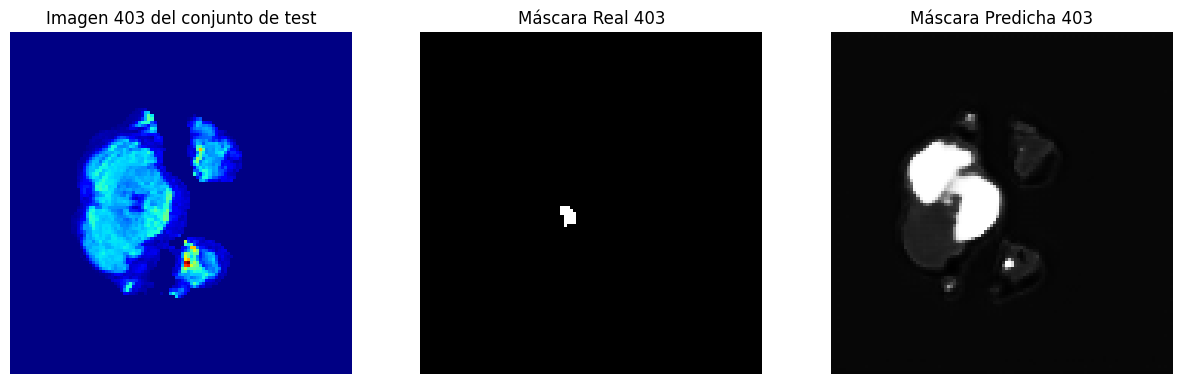

In [ ]:
num_images_to_display = 5
random_indices = random.sample(range(x_test.shape[0]), num_images_to_display)

for index in random_indices:
    predicted_mask = unet_model.predict(np.expand_dims(x_test[index], axis=0))
    predicted_mask = predicted_mask[0, :, :, 0] # Remove extra dimensions

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(x_test[index], cmap='jet')
    axes[0].set_title(f"Imagen {index} del conjunto de test")
    axes[0].axis('off')

    axes[1].imshow(y_test[index], cmap='gray')
    axes[1].set_title(f"Máscara Real {index}")
    axes[1].axis('off')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title(f"Máscara Predicha {index}")
    axes[2].axis('off')

    plt.show()

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation='relu'):
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same', kernel_initializer='he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    return x

In [ ]:
def residual_block(input_tensor, n_filters):
    #Conv1
    shortcut = input_tensor  # Store the original input for the residual connection
    x = conv2d_block(input_tensor, n_filters)
    #Conv2 (residual connection)
    x = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Ensure the shortcut has the same number of filters as 'x'
    shortcut = Conv2D(n_filters, (1, 1), padding='same', kernel_initializer='he_normal')(shortcut)
    shortcut = BatchNormalization()(shortcut)

    #Add the input tensor to the output (residual connection)
    x = Add()([x, shortcut])  # Use shortcut instead of the original input
    x = Activation('relu')(x)
    return x

In [ ]:
def get_Segnet(input_img, n_filters=16, dropout=0.1, batchnorm=True, leaky_relu=False):
    # Encoder
    x = conv2d_block(input_img, 64)
    x1 = MaxPooling2D((2, 2))(x)

    x = residual_block(x1, 128)
    x2 = MaxPooling2D((2, 2))(x)

    x = residual_block(x2, 256)
    x3 = MaxPooling2D((2, 2))(x)

    # Decoder
    x = UpSampling2D((2, 2))(x3)
    x = Conv2D(128, (3, 3), padding='same')(x)  # Adjust filters to match x2
    x = concatenate([x, x2])  # Concatenate with encoder part

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)  # Adjust filters to match x1
    x = concatenate([x, x1])  # Concatenate with encoder part

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

    model = tf.keras.Model(input_img, x)
    return model

In [ ]:
input_img = Input((112, 112, 1), name='img')
model = get_Segnet(input_img)
model.summary()
model.compile(
    optimizer=Adam(learning_rate=1e-2),
    loss=iou_loss,
    metrics=['binary_io_u']
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)          │ (None, 112, 112, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 112, 112, 64)   │            640 │ img[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 112, 112, 64)   │            256 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_45             │ (None, 112, 112, 64)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 56, 56, 64)     │              0 │ activation_45[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 56, 56, 128)    │            512 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_46             │ (None, 56, 56, 128)    │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ activation_46[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 56, 56, 128)    │          8,320 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 56, 56, 128)    │            512 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_52    │ (None, 56, 56, 128)    │            512 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 56, 56, 128)    │              0 │ batch_normalization_5… │
│                           │                        │                │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_47             │ (None, 56, 56, 128)    │              0 │ add_4[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 28, 28, 128)    │              0 │ activation_47[0][0]    │
│ (MaxPooling2D)       

 Total params: 1,597,249 (6.09 MB)

 Trainable params: 1,594,817 (6.08 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_segnet.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

results = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=5,
    validation_split=0.1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1), # Reduce LR on plateau
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        checkpoint_callback
    ]
)

Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_io_u: 0.4945 - loss: 0.9892
Epoch 1: val_loss improved from inf to 0.99004, saving model to best_segnet.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 1555s 6s/step - binary_io_u: 0.4945 - loss: 0.9892 - val_binary_io_u: 0.4950 - val_loss: 0.9900 - learning_rate: 0.0100
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_io_u: 0.4948 - loss: 0.9897
Epoch 2: val_loss did not improve from 0.99004
245/245 ━━━━━━━━━━━━━━━━━━━━ 1583s 6s/step - binary_io_u: 0.4948 - loss: 0.9897 - val_binary_io_u: 0.4950 - val_loss: 0.9900 - learning_rate: 0.0100
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_io_u: 0.4947 - loss: 0.9896
Epoch 3: val_loss did not improve from 0.99004
245/245 ━━━━━━━━━━━━━━━━━━━━ 1587s 6s/step - binary_io_u: 0.4947 - loss: 0.9896 - val_binary_io_u: 0.4950 - val_loss: 0.9900 - learning_rate: 0.0100
Epoch 4/5


KeyboardInterrupt: 

In [ ]:
segnet_model_path = '/content/best_segnet.keras'
segnet_model = tf.keras.models.load_model(segnet_model_path, compile=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


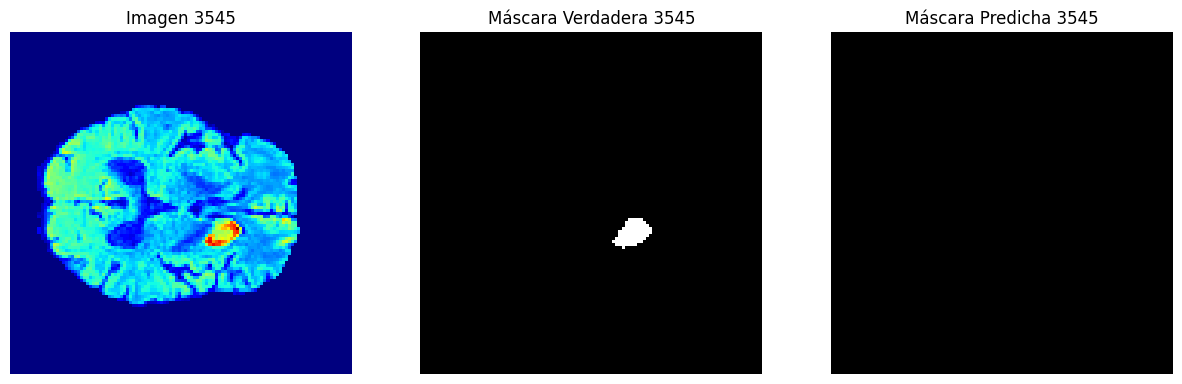

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


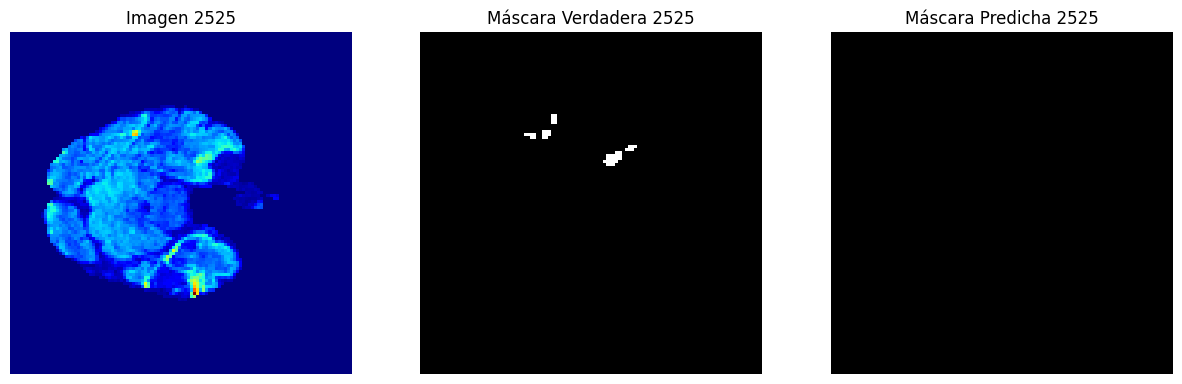

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


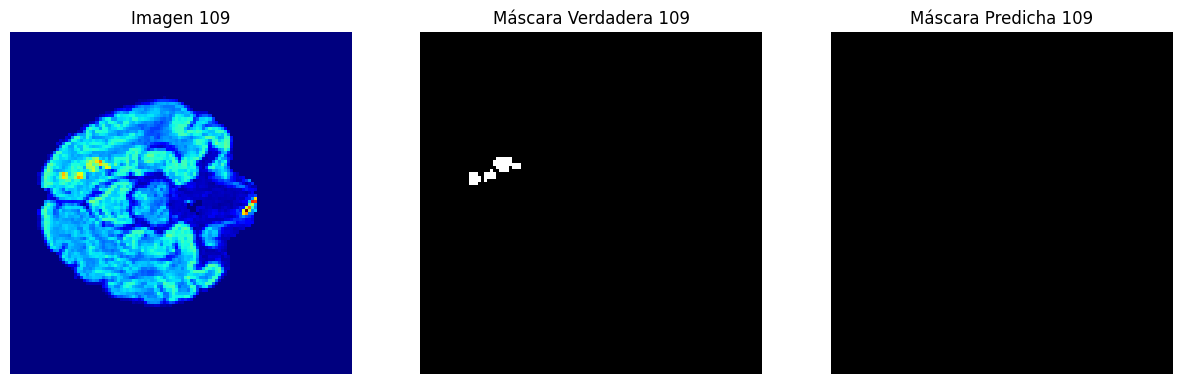

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


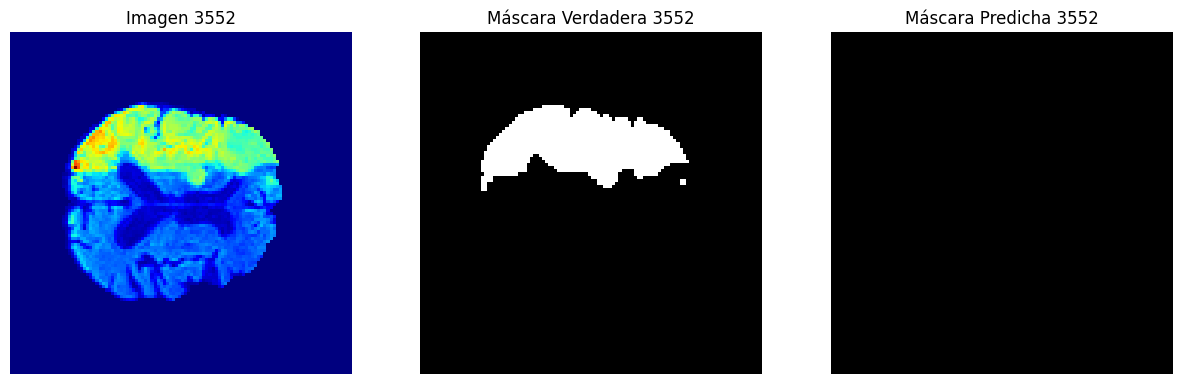

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


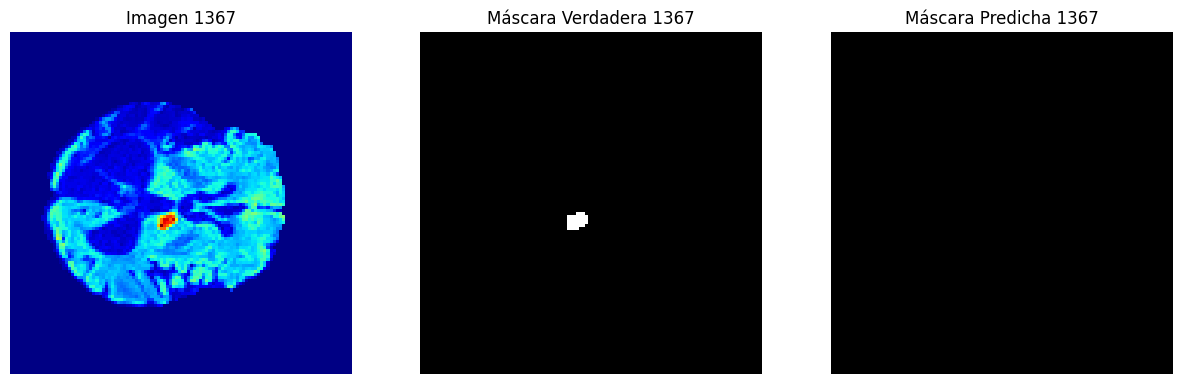

In [ ]:
num_images_to_display = 5
random_indices = random.sample(range(x_train.shape[0]), num_images_to_display)

for index in random_indices:
    predicted_mask = segnet_model.predict(np.expand_dims(x_train[index], axis=0))
    predicted_mask = predicted_mask[0, :, :, 0]  #Remove extra dimensions

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(x_train[index], cmap='jet')
    axes[0].set_title(f"Imagen {index}")
    axes[0].axis('off')

    axes[1].imshow(y_train[index], cmap='gray')
    axes[1].set_title(f"Máscara Verdadera {index}")
    axes[1].axis('off')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title(f"Máscara Predicha {index}")
    axes[2].axis('off')

    plt.show()